In [1]:
## add the sys function part else there will be file loading errors.
import sys
import warnings
sys.path.insert(1,'../functions')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import numpy as np
import io_pipe
import nd_index
import lst
import plot_utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import logging
from eolearn.io import get_available_timestamps
import pdb
import geopandas as gpd

/Users/sanchit/anaconda3/lib/python3.7/site-packages/eolearn/io/processing_api.py:176: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ProcApiType("bool_mask", 'DN', 'UINT8', np.bool, FeatureType.MASK): [


In [3]:
## delete all these package once you move the validate function
import datetime
from typing import Type
from sentinelhub import BBox, CRS, DataCollection, SHConfig
from eolearn.core import SaveTask, FeatureType, LinearWorkflow, EOPatch,OverwritePermission
from eolearn.io import SentinelHubInputTask
import geopandas as gpd


In [4]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
## add your sentinelhub credentials to start running this.
config_dict = {
            'INSTANCE_ID': None,
            'CLIENT_ID': None,
            'CLIENT_SECRET': None
        }

In [6]:
config_dict = {
            'INSTANCE_ID': '82f63741-572a-451c-905d-bd2575f2aad0',
            'CLIENT_ID': '4cac505f-9177-4874-ac2b-13c38b8ff178',
            'CLIENT_SECRET': ')5b0-PQyF%auI,8u>7Mv~^YhYJLMd_98Xe3>eeo5'
        }


In [7]:
vconfig = io_pipe.set_config(new_id=True,INSTANCE_ID=config_dict['INSTANCE_ID'],
                            CLIENT_ID= config_dict['CLIENT_ID'],
                            CLIENT_SECRET=config_dict['CLIENT_SECRET'])

In [8]:
year_range = range(2013,2020)
date_range = [1,30]
month = [6,9]

In [9]:
vtime_interval = []
for idx,val in enumerate(year_range):
    vstrt = str(val)+'-0'+str(month[0])+'-0'+str(date_range[0])
    vend = str(val)+'-0'+str(month[1])+'-'+str(date_range[1])
    vtime_interval.append((vstrt,vend))    

In [10]:
vdata = []
vtimestamp = []
vMask = []
vcloud_coverage=.2
for i in range(len(vtime_interval)):
    try:
        vband = io_pipe.get_landsat8(time_interval=vtime_interval[i],
                                          maxcc=vcloud_coverage,
                                          config=vconfig)
        vM = vband.mask['dataMask']
        ## images which have data mask and we want to remove if the list is not empty
        vNot = list(set(np.where(vM==False)[0]))
        ## if the vNot lise is empty it implies that all the images fethced in this case 
        ## don't have any masking and so we can just add the timestamp data and bands data to our list
        if not vNot:
            vdata.append(vband.data['L1C_data'])
            for i in vband.timestamp:
                vtimestamp.append(i)
        else:
            ## in case vNot list is not empty we should find all images which might 
            ## not have masking and add only them.
            vInd= [i for i in range(vM.shape[0]) if i not in vNot]
            if vInd:
#                print("Some of the images in this interval are corrupted {}".format(vtime_interval[i]))
                vdata.append(vband.data['L1C_data'][vInd,:,:,:])
#                print("Indices which are corrupted are {}".format(vNot))
#                print("Indices which are good are {}".format(vInd))
                for i in vInd:
                    vtimestamp.append(vband.timestamp[i])
                                                            
            else:
                print("All the fetched image have corrupted data hence not added time_interval {}"
                      .format(vtime_interval[i],vcloud_coverage))
                continue;
                
                
    except:
        print("No image exists for the parameters: time interval {},cloud coverage: {},".format(vtime_interval[i],
                                                                                                vcloud_coverage))
eopatch_data = np.concatenate(vdata,axis=0)
#vMask = np.concatenate(vMask,axis=0)

All the fetched image have corrupted data hence not added time_interval ('2013-06-01', '2013-09-30')


In [11]:
eopatch_data.shape

(12, 1082, 1312, 12)

In [13]:
NDVI_REF = nd_index.calc_ndvi(eopatch_data)

In [14]:
B10 = eopatch_data[:,:,:,9]-273
B11 = eopatch_data[:,:,:,10]-273
#RADIANCE_ADD_BAND_10 = 0.10000
#RADIANCE_MULT_BAND_10 = 3.3420E-04
#K1_CONSTANT_BAND_10 = 774.8553
#K2_CONSTANT_BAND_10 = 1321.0789

In [15]:
vLSE = lst.LSE(NDVI_REF)
vLST = lst.mono_LST(B10,vLSE)

In [16]:
## use datamask for plot/NDVI/LST.
vR = eopatch_data[:,:,:,3]
vG = eopatch_data[:,:,:,2]
vB = eopatch_data[:,:,:,1]
vImg = np.stack([vR,vG,vB],axis =3)
vImg = (vImg *(255/  np.max(vImg))).astype(np.uint8)
vImg = (vImg*(3.5/255))

In [17]:
def plot_LST_true(True_Image,LST,date,cmp=None):
    # to remove the clipping warning/logging. 
#    pdb.set_trace()
    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    ## the above part is only to remove the clipping warning and has no other relevance to the plot code.
    if cmp is not None:
        norm = Normalize(vmin=cmp[0],vmax=cmp[1])        
    else:
        norm = Normalize(vmin=np.min(LST),vmax=np.max(LST))        

    plt.rcParams['figure.figsize'] = [12, 8]    
    f, (ax1,ax2) = plt.subplots(1,2)
    im = ax2.imshow(LST,cmap=plt.cm.jet,norm=norm)
    f.colorbar(im,orientation="horizontal",fraction=0.07)
    ax1.imshow(True_Image)
    ax1.set_title(date)
    plt.show()

    

In [18]:
def plot_all_LST(True_Image,LST,date):
    vmax = np.max(LST)
    vmin = np.min(LST)
    cmp = (vmax,vmin)
    assert True_Image.shape[:-1] == LST.shape
    vSze = True_Image.shape[0]
    for i in range(vSze):
        plot_LST_true(True_Image[i],LST[i],date[i],cmp = None )
        #plot_LST_true(True_Image[i],LST[i],date[i],cmp = cmp )

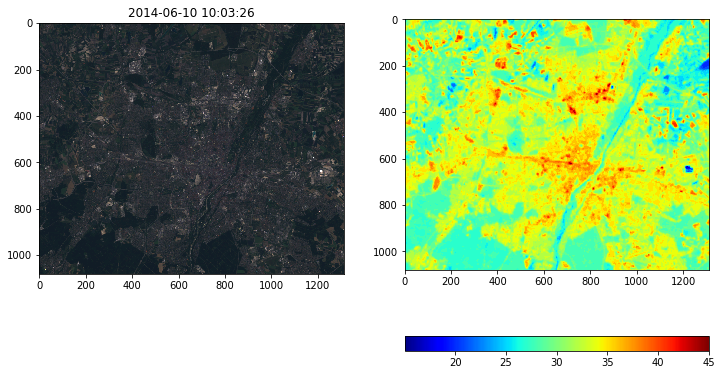

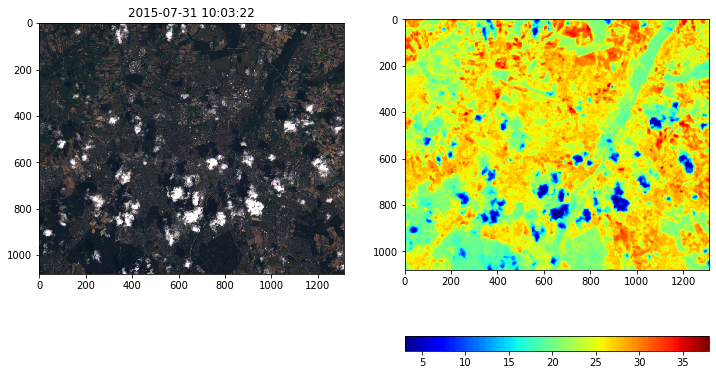

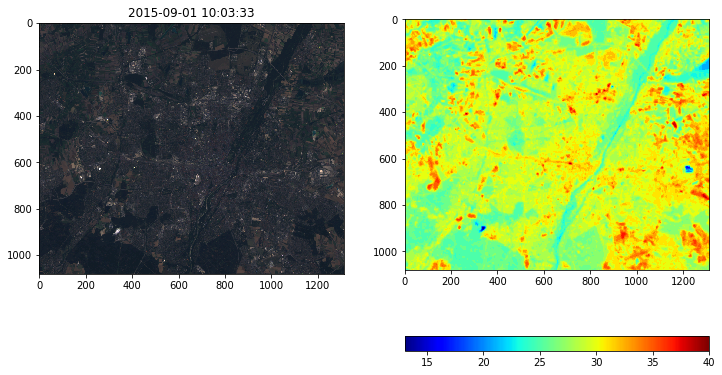

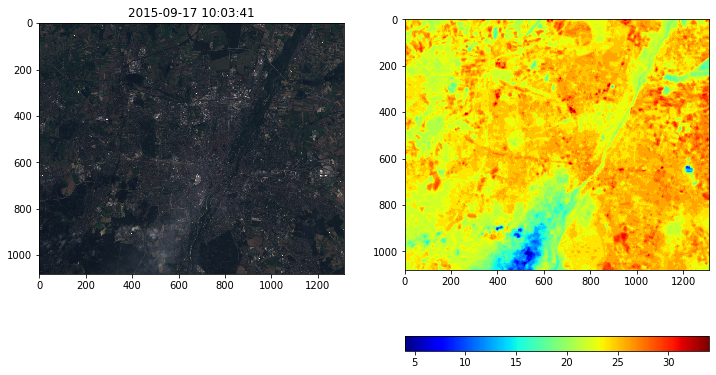

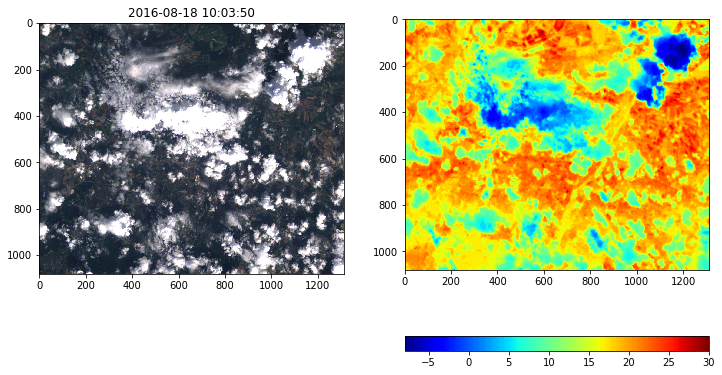

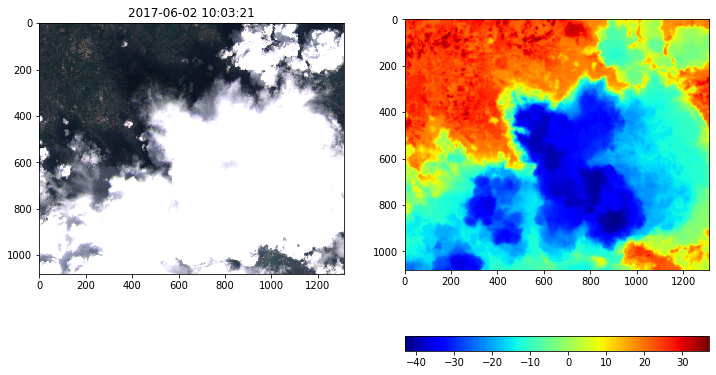

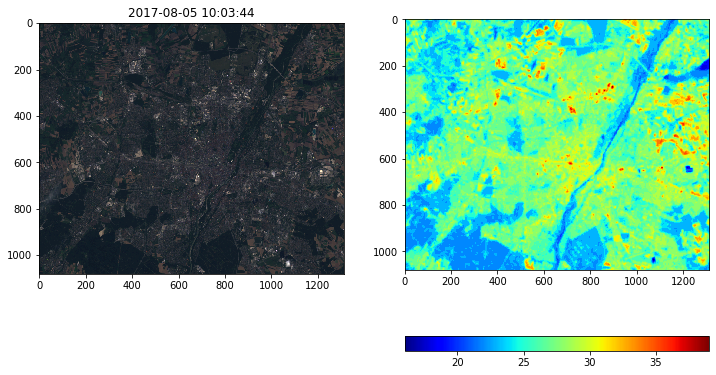

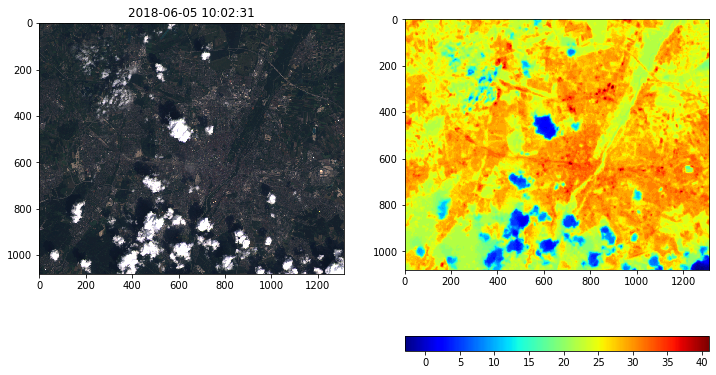

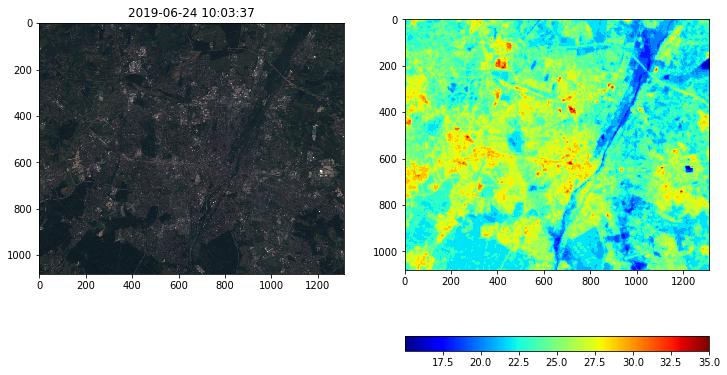

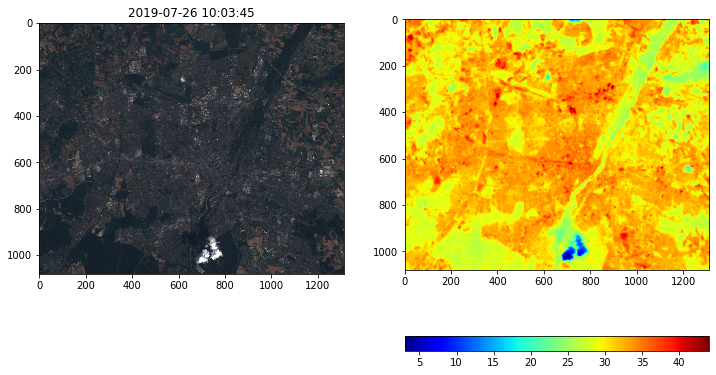

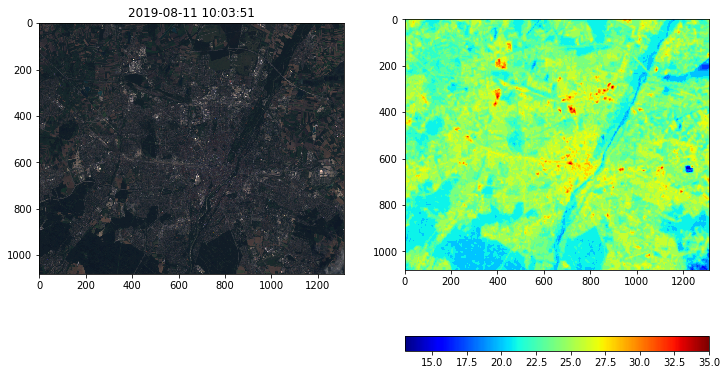

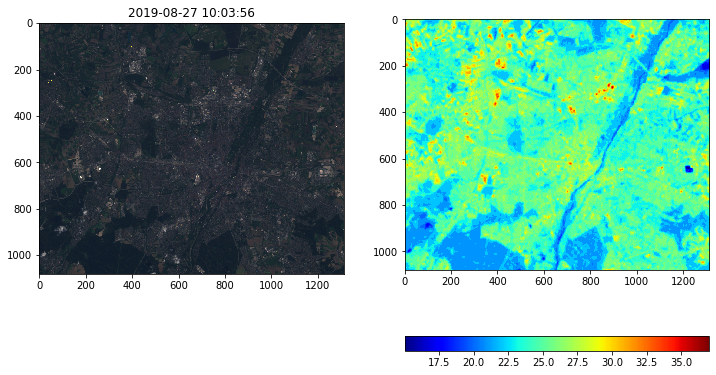

In [19]:
plot_all_LST(vImg,vLST,vtimestamp)